In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [5]:
meta_data= pd.read_csv("C:/Users/LARBI/Desktop/traveaux master2 info/semestre2/etude de cas decisionnel/data/training_set_metadata.csv")

meta_data.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [6]:
training_set = pd.read_csv("C:/Users/LARBI/Desktop/traveaux master2 info/semestre2/etude de cas decisionnel/data/training_set.csv")
training_set.describe()

,object_id,mjd,passband,flux,flux_err,detected
count,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06,1.421705e+06
mean,3.392608e+07,6.017921e+04,2.783108e+00,2.468855e+01,2.548932e+01,1.666168e-01
std,4.258439e+07,3.092379e+02,1.703946e+00,3.684506e+03,3.814492e+03,3.726336e-01
min,6.150000e+02,5.958003e+04,0.000000e+00,-1.149388e+06,4.637530e-01,0.000000e+00
25%,1.843400e+05,5.989905e+04,1.000000e+00,-2.789418e+00,2.118670e+00,0.000000e+00
50%,4.548783e+06,6.019331e+04,3.000000e+00,7.331990e-01,4.708105e+00,0.000000e+00
75%,6.796280e+07,6.048722e+04,4.000000e+00,8.830932e+00,1.297371e+01,0.000000e+00
max,1.307798e+08,6.067436e+04,5.000000e+00,2.432809e+06,2.234069e+06,1.000000e+00


In [7]:
%matplotlib inline

In [8]:
targets = np.hstack([np.unique(meta_data['target']), [99]])
target_map = {j:i for i, j in enumerate(targets)}
target_ids = [target_map[i] for i in meta_data['target']]
meta_data['target_id'] = target_ids

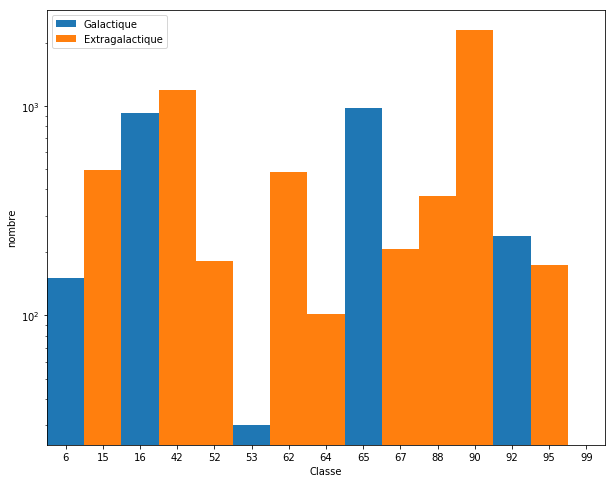

In [9]:
galactic_cut = meta_data['hostgal_specz'] == 0
plt.figure(figsize=(10, 8))
plt.hist(meta_data[galactic_cut]['target_id'], 15, (0, 15), label='Galactique')
plt.hist(meta_data[~galactic_cut]['target_id'], 15, (0, 15), label='Extragalactique')
plt.xticks(np.arange(15)+0.5,   targets)
plt.gca().set_yscale("log")
plt.xlabel('Classe')
plt.ylabel('nombre')
plt.xlim(0, 15)
plt.legend();

In [10]:
target_types={6:'Microlensing', 15:'Explosive Type V', 16:'Transits', 42:'Explosive type W', 52:'Explosive Type X', 
                  53:'Long periodic', 62:'Explosive Type Y', 64:'Near Burst', 65:'Flare', 67:'Explosive Type Z',
                  88:'AGN', 90:'SN Type U', 92:'Periodic', 95:'SN Type T'}


In [11]:
object_list=times.groupby('object_id').apply(lambda x: x['object_id'].unique()[0]).tolist()


NameError: name 'times' is not defined

In [12]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']

def plot_one_object(obj_id):
        
    for band in range(len(colors)):
        sample = train_series[(train_series['object_id'] == obj_id) & (train_series['passband']==band)]
        plt.errorbar(x=sample['mjd'],y=sample['flux'],yerr=sample['flux_err'],c = colors[band],fmt='o',alpha=0.7)

In [13]:
for t in sorted(meta_data['target'].unique()):
    print (t,meta_data[meta_data['target']== t]['target'].count(),target_types[t],meta_data[meta_data['target']== t]['hostgal_specz'].mean())

6 151 Microlensing 0.0
15 495 Explosive Type V 0.2435767676767677
16 924 Transits 0.0
42 1193 Explosive type W 0.22996244761106457
52 183 Explosive Type X 0.2297060109289617
53 30 Long periodic 0.0
62 484 Explosive Type Y 0.19497045454545456
64 102 Near Burst 0.07439803921568627
65 981 Flare 0.0
67 208 Explosive Type Z 0.22544855769230768
88 370 AGN 0.9679970270270271
90 2313 SN Type U 0.36308127972330306
92 239 Periodic 0.0
95 175 SN Type T 1.2174382857142858


In [14]:
null_columns=meta_data.columns[meta_data.isnull().any()]
meta_data[null_columns].isnull().sum()

distmod    2325
dtype: int64

In [15]:
groups = training_set.groupby(['object_id', 'passband'])

In [16]:
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})
flux = groups.apply(
    lambda block: block['flux'].values
).reset_index().rename(columns={0: 'seq'})
err = groups.apply(
    lambda block: block['flux_err'].values
).reset_index().rename(columns={0: 'seq'})
det = groups.apply(
    lambda block: block['detected'].astype(bool).values
).reset_index().rename(columns={0: 'seq'})
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
err_list = err.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
det_list = det.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()


In [17]:
flux.head()

,object_id,passband,seq
0,615,0,"[6.878784, 39.364853000000004, -10.422381, -65..."
1,615,1,"[-816.4343259999999, -1061.4570310000001, -815..."
2,615,2,"[-544.810303, -681.858887, -548.01355, -554.90..."
3,615,3,"[-471.385529, -524.95459, -475.51605199999995,..."
4,615,4,"[-388.984985, -393.480225, -405.663818, -400.2..."


In [18]:
object_list=times.groupby('object_id').apply(lambda x: x['object_id'].unique()[0]).tolist()


In [19]:
colors = ['purple', 'blue', 'green', 'orange', 'red', 'black']

def plot_one_object(obj_id):
        
    for band in range(len(colors)):
        sample = training_set[(training_set['object_id'] == obj_id) & (training_set['passband']==band)]
        plt.errorbar(x=sample['mjd'],y=sample['flux'],yerr=sample['flux_err'],c = colors[band],fmt='o',alpha=0.7)

In [20]:
for t in sorted(meta_data['target'].unique()):
    print (t,meta_data[meta_data['target']== t]['target'].count(),target_types[t],meta_data[meta_data['target']== t]['hostgal_specz'].mean())

6 151 Microlensing 0.0
15 495 Explosive Type V 0.2435767676767677
16 924 Transits 0.0
42 1193 Explosive type W 0.22996244761106457
52 183 Explosive Type X 0.2297060109289617
53 30 Long periodic 0.0
62 484 Explosive Type Y 0.19497045454545456
64 102 Near Burst 0.07439803921568627
65 981 Flare 0.0
67 208 Explosive Type Z 0.22544855769230768
88 370 AGN 0.9679970270270271
90 2313 SN Type U 0.36308127972330306
92 239 Periodic 0.0
95 175 SN Type T 1.2174382857142858


In [21]:
def fit_kernel_length_only(times_band,flux_band,err_band):
    
    def _kernel_likelihood(length):
        sigma=siguess
        #length=params
        kernel=np.exp(-(np.reshape(times_band,(-1,1)) - times_band)**2/2/length**2)
        np.fill_diagonal(kernel,0)
        sumw=kernel.dot(1./err_band**2) + 1./sigma**2
        pred=kernel.dot(flux_band/err_band**2) / sumw
        chi2 = (pred - flux_band)**2 / ( err_band**2 + 1./sumw )
        # -2 ln likelihood
        logl=np.sum(chi2 + np.log(err_band**2 + 1./sumw))
        return logl
    
    lguess=(np.max(times_band)-np.min(times_band))/len(times_band)
    siguess=np.std(flux_band)
    output=optimize.fmin(_kernel_likelihood,lguess,disp=False,xtol=0.01,full_output=1)
    return (siguess,output[0][0]), output[1]

In [22]:
def kernel_predict(params,times_band,flux_band,err_band):
    sigma=params[0]
    length=params[1]
    kernel=np.exp(-(np.reshape(time_grid,(-1,1)) - times_band)**2/2/length**2)
    sumw=kernel.dot(1./err_band**2) + 1./sigma**2
    pred=kernel.dot(flux_band/err_band**2) / sumw
    return pred, np.sqrt(1./sumw)

In [23]:
def make_kernel(tlist,flist,elist,fit_kernel_function=fit_kernel_length_only):
    flux_grid = []
    err_grid = []
    kernel_sigma = []
    kernel_length = []
    kernel_logl=[]
    for iobj,(times_obj,flux_obj,err_obj) in enumerate(zip(tlist,flist,elist)):
        flux_grid_obj=[]
        err_grid_obj=[]
        kernel_sigma_obj = []
        kernel_length_obj = []
        kernel_logl_obj=[]
        if iobj in meta_data[meta_data['hostgal_photoz']!=0.0].index:
            for times_band,flux_band,err_band in zip(times_obj,flux_obj,err_obj):
                (sigma,length),logl = fit_kernel_function(times_band,flux_band,err_band)
                k_flux,k_err=kernel_predict((sigma,length),times_band,flux_band,err_band)
                flux_grid_obj.append(k_flux)
                err_grid_obj.append(k_err)
                kernel_sigma_obj.append(sigma)
                kernel_length_obj.append(length)
                kernel_logl_obj.append(logl)
        else:
            kernel_sigma_obj=[0]*6
            kernel_length_obj=[0]*6
            kernel_logl_obj=[0]*6
        flux_grid.append(flux_grid_obj)
        err_grid.append(err_grid_obj)
        kernel_sigma.append(kernel_sigma_obj)
        kernel_length.append(kernel_length_obj)
        kernel_logl.append(kernel_logl_obj)
    return flux_grid,err_grid, kernel_sigma, kernel_length,kernel_logl

6.392560656046845 7.689738021763396 191.19034136718196


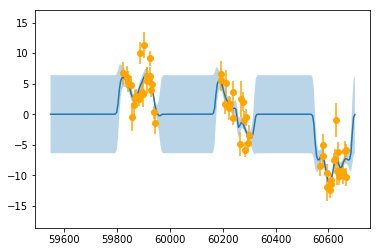

In [24]:
iobj=1
band=3
time_grid=(np.arange(59550,60705,5.))
(sigma,length),logl = fit_kernel_length_only(times_list[iobj][band],flux_list[iobj][band],err_list[iobj][band])
#length=4.0
k_flux,k_err=kernel_predict((sigma,length),times_list[iobj][band],flux_list[iobj][band],err_list[iobj][band])
plt.errorbar(times_list[iobj][band],flux_list[iobj][band],yerr=err_list[iobj][band],color=colors[band],fmt='o')
plt.plot(time_grid,k_flux)
plt.fill_between(time_grid,k_flux-k_err,k_flux+k_err,alpha=0.3)
plt.ylim(np.min(flux_list[iobj][band]*1.5,0),np.max(flux_list[iobj][band]*1.5,0))
#plt.xlim(60100,60300)
print (sigma,length,logl)

In [25]:
klonly_flux_grid,klonly_err_grid,klonly_sigma,klonly_length,klonly_logl = make_kernel(
    times_list,flux_list,err_list,fit_kernel_function=fit_kernel_length_only)

C:\Users\LARBI\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\LARBI\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\LARBI\AppData\Local\Programs\Python\Python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


(60000, 60250)

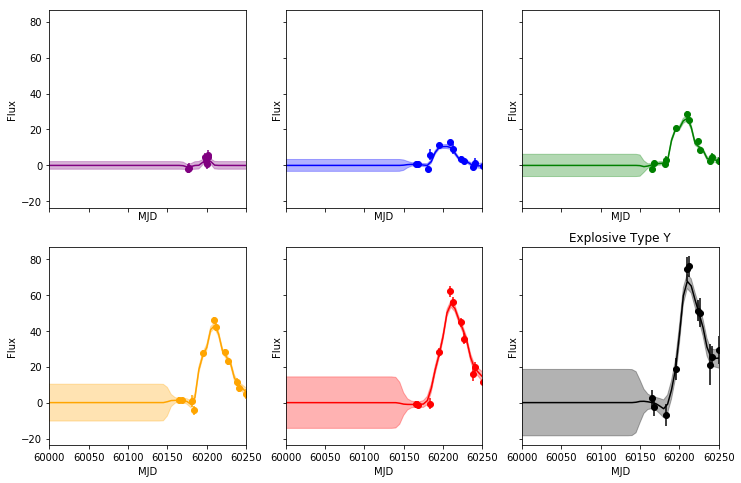

In [26]:
def plot_interpolations(iobj,times_list,flux_list,err_list,flux_grid,err_grid):
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 8))
    plt.title(target_types[meta_data.loc[iobj,'target']]) 
    for band in range(6):
        ax = axes[band // 3, band % 3]
        ax.errorbar(times_list[iobj][band],flux_list[iobj][band],yerr=err_list[iobj][band],color=colors[band],fmt='o')
        ax.plot(time_grid,flux_grid[iobj][band],color=colors[band])
        ax.fill_between(time_grid,flux_grid[iobj][band]-err_grid[iobj][band],
                        flux_grid[iobj][band]+err_grid[iobj][band],alpha=0.3,color=colors[band])
        ax.set_xlabel('MJD')
        ax.set_ylabel('Flux')
    plt.title(target_types[meta_data.loc[iobj,'target']])
plot_interpolations(300,times_list,flux_list,err_list,klonly_flux_grid,klonly_err_grid)
#plt.ylim(-50,200)
plt.xlim(60000,60250)

C:\Users\LARBI\AppData\Local\Programs\Python\Python37-32\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


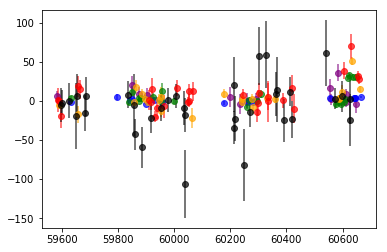

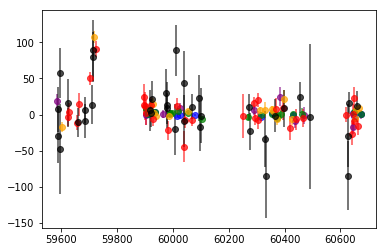

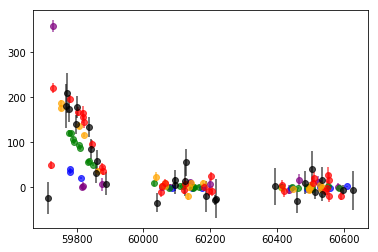

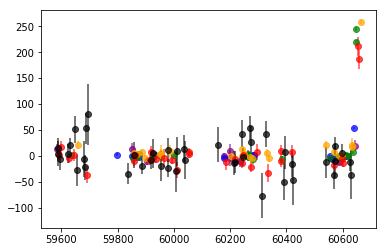

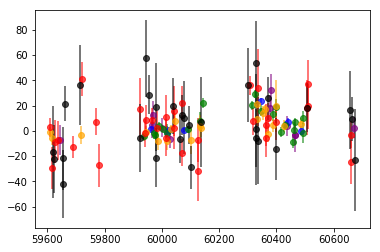

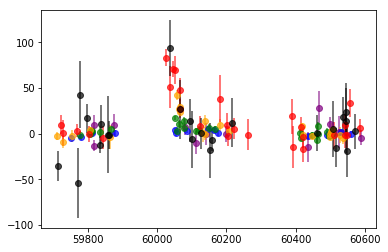

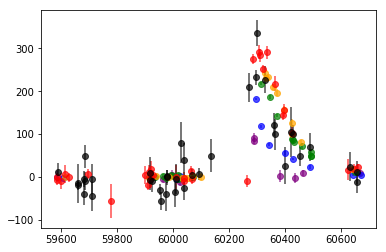

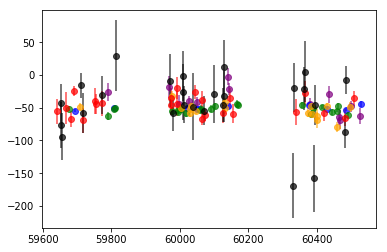

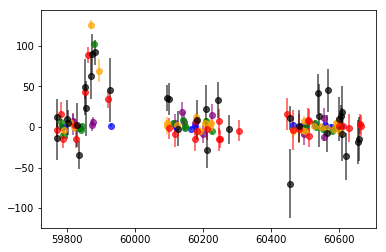

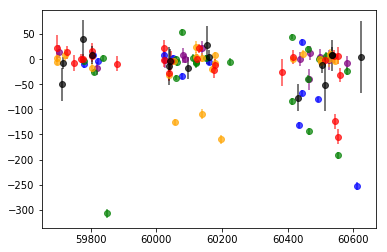

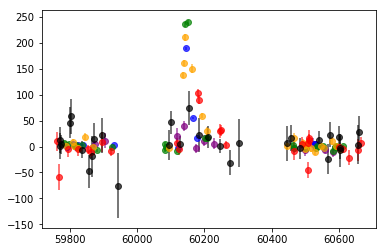

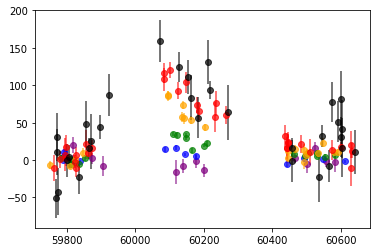

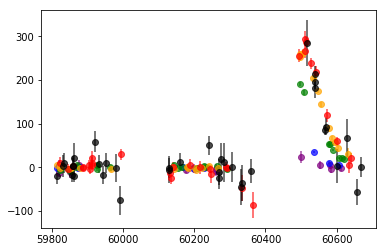

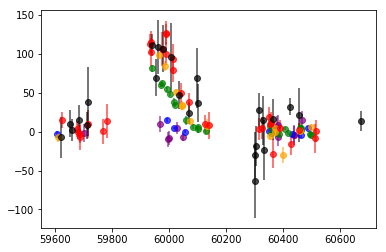

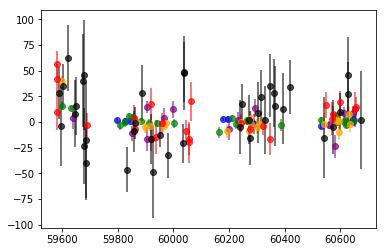

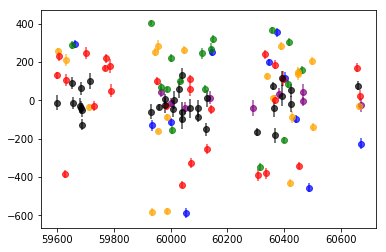

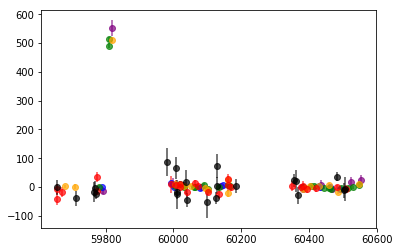

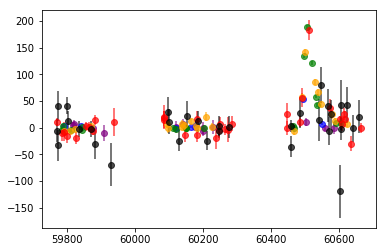

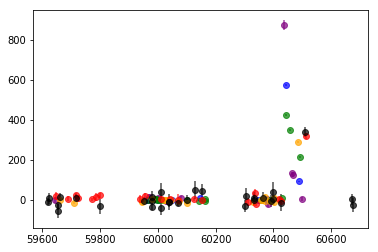

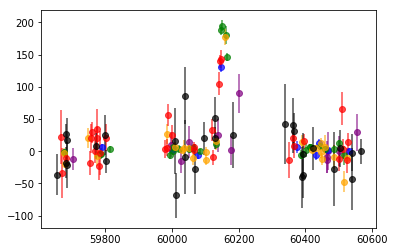

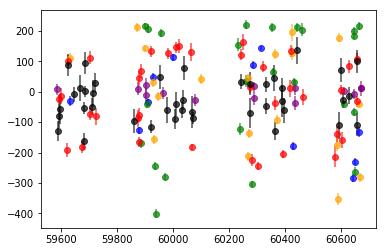

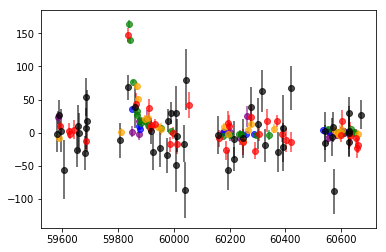

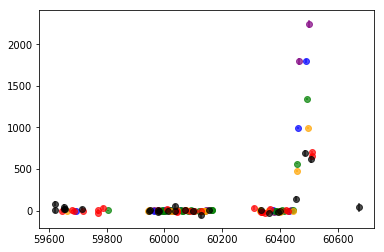

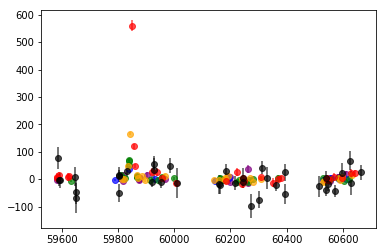

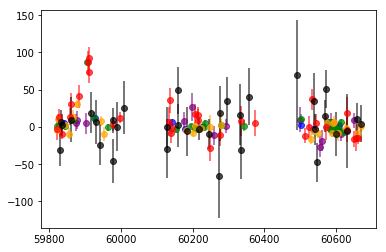

In [27]:
for iobj in meta_data[(meta_data['ddf']==0)]['object_id'][:25]:
   plt.figure()
   plot_one_object(iobj)

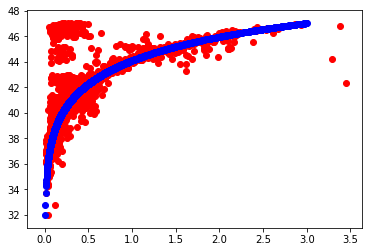

In [28]:
x1=meta_data["hostgal_specz"].tolist()
x2=meta_data["hostgal_photoz"].tolist()
plt.scatter(x1, meta_data["distmod"],color = 'red');
plt.scatter(x2, meta_data["distmod"],color = 'blue');

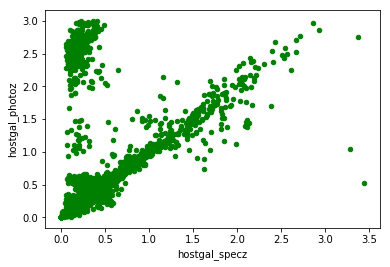

In [29]:
true_photoz= meta_data[~meta_data.hostgal_specz.isna()==~meta_data.hostgal_photoz.isna()]
true_photoz.plot.scatter(x="hostgal_specz", y="hostgal_photoz",color = 'green');

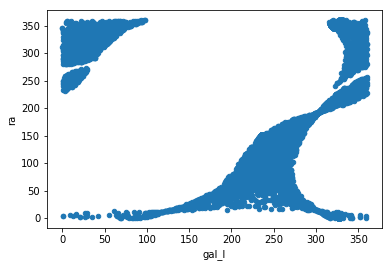

In [30]:
meta_data.plot.scatter(x="gal_l", y="ra")

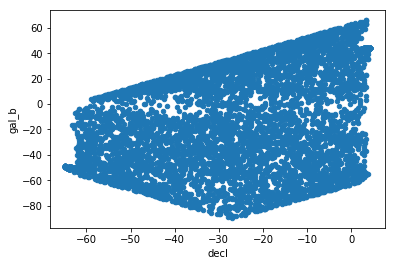

In [31]:
meta_data.plot.scatter(x="decl", y="gal_b")

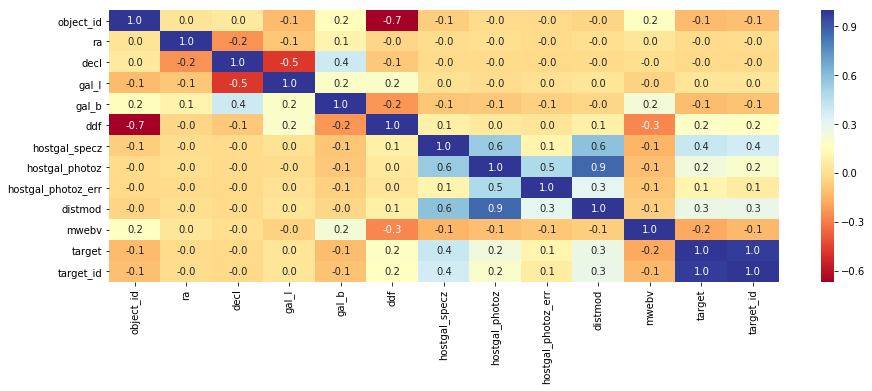

In [32]:

plt.figure(figsize=(15,5))
sns.heatmap(meta_data.corr(), annot=True, fmt=".1f", cmap="RdYlBu");

In [33]:
# lest attribut correles dans les metadata sont:
#distmod et hostgal_fotoz.
#target et target_id
#decl avec gal_l
#ddf avec object_id

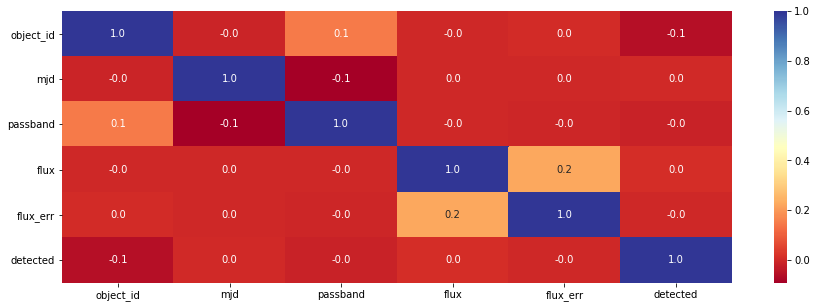

In [34]:

plt.figure(figsize=(15,5))
sns.heatmap(training_set.corr(), annot=True, fmt=".1f", cmap="RdYlBu");

In [115]:
brut_data=meta_data[~meta_data.distmod.isna()]
data=brut_data[1:1000]

In [116]:
data.distmod.head()

2    40.2561
3    40.7951
4    40.4166
6    39.7279
7    43.1524
Name: distmod, dtype: float64

In [ ]:
X

In [122]:
mpoll = np.mean(brut_data.distmod)
sigpoll = 100.
pred_distmod = np.array(data.distmod/sigpoll)
X = (np.atleast_2d(data.hostgal_photoz).T).astype(float)
y = pred_distmod - (mpoll)/sigpoll
#dy = 0.1*np.ones(len(y))/sigpoll#one point error
dy = pred_distmod*(1-pred_distmod)/data.distmod.values
Y=data.distmod

In [123]:
X

array([[0.2262],
       [0.2813],
       [0.2415],
       [0.182 ],
       [0.7014],
       [0.3229],
       [0.19  ],
       [0.5409],
       [2.7474],
       [0.5736],
       [0.1469],
       [0.1274],
       [0.1818],
       [1.1213],
       [1.4377],
       [2.6766],
       [0.4644],
       [0.0556],
       [0.5512],
       [0.1322],
       [0.2205],
       [0.5995],
       [0.287 ],
       [0.2487],
       [0.2685],
       [0.3983],
       [0.5667],
       [0.085 ],
       [0.4245],
       [0.1337],
       [0.5176],
       [0.1876],
       [0.082 ],
       [0.4808],
       [0.6136],
       [1.2719],
       [0.1111],
       [0.0719],
       [1.1162],
       [0.6725],
       [0.2233],
       [0.6017],
       [0.1711],
       [0.1872],
       [0.1415],
       [0.5095],
       [0.2171],
       [0.5279],
       [0.4605],
       [2.447 ],
       [0.5192],
       [0.5624],
       [0.3449],
       [0.3115],
       [0.3816],
       [0.5728],
       [0.2634],
       [0.2359],
       [1.1667

In [124]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

In [126]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y) ** 2,
                              n_restarts_optimizer=10)


In [128]:
gp.fit(X, Y)

GaussianProcessRegressor(alpha=array([0.35139, 1.59451, ..., 0.06332, 2.19783]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [129]:
GaussianProcessRegressor(alpha=np.array([  2.91595e-05,   3.03287e-05, ...,   3.15727e-05,   4.14705e-04]),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

GaussianProcessRegressor(alpha=array([2.91595e-05, 3.03287e-05, Ellipsis, 3.15727e-05, 0.000414705],
      dtype=object),
             copy_X_train=True, kernel=1**2 * RBF(length_scale=10),
             n_restarts_optimizer=10, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [142]:
#x = np.atleast_2d(np.linspace(-250., 0, 1000)).T
x=[data["hostgal_photoz"]]
#y_pred, sigma = gp.predict(x, return_std=True)


In [143]:
import math
distmods=[]
for row in meta_data.itertuples():
    distmod=row.distmod
    if math.isnan(distmod):
        distmod=gp.predict([[row.hostgal_photoz]])[0]
        
    distmods.append(distmod)
        

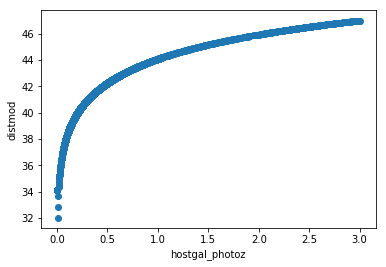

In [169]:
#fig = plt.figure()
#py = sigpoll*y+mpoll
#pdy = sigpoll*dy
#py_pred = sigpoll*y_pred+mpoll
#psigma = sigpoll*sigma
#plt.errorbar(X.ravel(), py, pdy, fmt='r.', markersize=10, label=u'Observations')
plt.scatter(meta_data["hostgal_photoz"], distmods)
#plt.fill(np.concatenate([x, x[::-1]]),
 #        np.concatenate([py_pred - 1.9600 * psigma,
  #                      (py_pred + 1.9600 * psigma)[::-1]]),
   #      alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('hostgal_photoz')
plt.ylabel('distmod')
#plt.ylim(0., 80.)
#plt.xlim(-5.,5.)
#plt.legend(loc='upper left')

plt.show()

In [171]:
score= gp.score(X,Y)
score

0.9982126092741981